# **`FRED API`**

We will make use of an API provided by the Federal Reserve Bank of St Louis.

The API is designed to facilitate the retrieval of economic data from FRED, which is a comprehensive source for U.S. economic data provided by the Federal Reserve Bank of St. Louis.

We chose to use the FRED API as it provides easy access to reliable economic data that is relevant to our analysis of the Exchange Rate between the US Dollar and the Mexican Peso.  As well as exchange rates, you can access a variety of economic data such as the Fed Rate, US and Mexican T-Bill rates, GDP, inflation and oil prices.

Please see https://fred.stlouisfed.org/ for more information on the available data.

In order to make use of the API, it is necessary to install the api via the command:

!pip install fredapi

### Import Required Libraries and Set Up Environment Variables

In [1]:
# Install Fred API and Prophet libraries
!pip install fredapi
!pip install prophet

In [2]:
# Dependencies
# Clean up and delete the import that is not required
import numpy as np
import requests
import time
# from dotenv import load_dotenv
import os
import pandas as pd
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import seaborn as sns
from prophet import Prophet

# load_dotenv()

# from fredapi is a library that provides functionality to interact with the
# FRED (Federal Reserve Economic Data).
# import Fred imports the Fred class (or function) from the fredapi module.
# The fred variable can call methods defined in the Fred class to access
# economic data from the FRED API.


from fredapi import Fred

#### The US dollar (USD) to Mexican peson (MXN) foreign exchange rate.
#### Imagine you are an American going on a vacation to Mexico in three months.   
#### You can exchange your hard earned USD to MXN now or wait until you arrive
#### in Mexico. This project will help you to make an informed decision.  Better
#### yet, you can then learn to apply this methodology when you travel to other
#### foreign countries.

### Access Fred data using api_key

In [3]:
# Initializes a new object of the Fred class and assigns it to the variable
# fred.
# This api_key is used for authentication when making requests to the
# FRED (Federal Reserve Economic Data) API.
# Later need to store the api_key in .env
# FRED is a free and reliable government data source.

fred = Fred(api_key="76b3e944bbc0ad36e888dff895f8c750")


The data being fetched below is crucial for understanding the economic relationship between the U.S. and Mexico, particularly in the context of exchange rates.
### Data Sets Explained:
**Exchange Rate (DEXMXUS):**

Description: This series represents the exchange rate between the U.S. dollar (USD) and the Mexican peso (MXN).

Importance: The exchange rate is a direct reflection of the value of one currency in terms of another. It is influenced by various economic factors, including interest rates, inflation, and economic growth, making it essential for understanding currency valuation.

**U.S. Federal Funds Rate (FEDFUNDS):**

Description: This is the interest rate at which banks lend reserve balances to other depository institutions overnight.

Importance: The federal funds rate is a key tool of U.S. monetary policy. Changes in this rate can influence economic activity, inflation, and ultimately, the exchange rate. Higher interest rates typically attract foreign capital, increasing demand for the USD and potentially strengthening it against other currencies, including the MXN.

**U.S. 90-Day Treasury Bill Rate (TB3MS):**

Description: This rate reflects the yield on U.S. Treasury bills with a maturity of 90 days.

Importance: Treasury bill rates are considered a risk-free benchmark for short-term interest rates. They influence other interest rates in the economy and can impact investor decisions regarding currency investments. A higher T-bill rate may attract foreign investors, increasing demand for the USD.

**Mexico's 90-Day Treasury Bill Rate (INTGSTMXM193N):**

Description: This rate represents the yield on Mexican Treasury bills with a maturity of 90 days.

Importance: Similar to the U.S. T-bill rate, this rate reflects the risk-free return available in Mexico. If the rate is higher than that of the U.S., it may attract investment into Mexico, increasing demand for the MXN and potentially affecting the exchange rate.

**U.S. Real GDP (GDPC1):**

Description: This is the inflation-adjusted measure of the total economic output of the U.S.

Importance: GDP growth indicates the health of the economy. Strong economic growth can lead to higher interest rates as the central bank may raise rates to control inflation, which can strengthen the USD against other currencies.

**Mexico's Real GDP (NGDPRSAXDCMXQ):**

Description: This is the inflation-adjusted measure of Mexico's total economic output.

Importance: Similar to the U.S. GDP, growth in Mexico's GDP can influence the strength of the MXN. If Mexico's economy is growing faster than the U.S. economy, it may lead to a stronger MXN relative to the USD.

**Summary**

In summary, these data points are interconnected and provide insights into the economic conditions of both the U.S. and Mexico. By analyzing trends in interest rates, GDP growth, and exchange rates, the project team can make informed predictions about currency movements and the overall economic relationship between the two countries to benefit our project use case(s).

In [4]:
# Fetch data using fred.get_series().

# Removing start date from API calls as does not seem to have any impact to the data being returned

# Use variable to store startd_date
#start_date = "2010-01-01"

# Exchange rate: $1 equals Mexican pesos
#exchange_rate = fred.get_series("DEXMXUS", start=start_date)
exchange_rate = fred.get_series("DEXMXUS")

# U.S. fed rate
#fed_rate = fred.get_series("FEDFUNDS", start=start_date)
fed_rate = fred.get_series("FEDFUNDS")

# U.S. 90-days T-bill rate
#t_bill_rate = fred.get_series('TB3MS', start=start_date)
t_bill_rate = fred.get_series('TB3MS')

# Mexico 90-days T-bill rate
#mx_t_bill_rate = fred.get_series('INTGSTMXM193N', start=start_date)
mx_t_bill_rate = fred.get_series('INTGSTMXM193N')

# U.S. Real GDP, adjusted for inflation
#us_gdp = fred.get_series('GDPC1', start=start_date)
us_gdp = fred.get_series('GDPC1')

# Mexico Real GDP, adjusted for inflation
#mx_gdp = fred.get_series('NGDPRSAXDCMXQ', start=start_date)
mx_gdp = fred.get_series('NGDPRSAXDCMXQ')

# U.S. Inflation rate
#us_cpi = fred.get_series('CPIAUCSL', start=start_date)
us_cpi = fred.get_series('CPIAUCSL')

# Mexico Inflation rate
#mx_cpi = fred.get_series('MEXCPIALLMINMEI', start=start_date)
mx_cpi = fred.get_series('MEXCPIALLMINMEI')

# U.S. Unemployment
#us_unr = fred.get_series('UNRATE', start=start_date)
us_unr = fred.get_series('UNRATE')

# Mexico Unemployment
#mx_unr = fred.get_series('LRUN64TTMXA156N', start=start_date)
mx_unr = fred.get_series('LRUN64TTMXA156N')

# Oil prices - West Texas Intermediate (WTI) crude oil price in dollars per barrel
#oil_price = fred.get_series('DCOILWTICO', start=start_date)
oil_price = fred.get_series('DCOILWTICO')


### Create master DataFrame containing all data.

In [5]:
# Select series from https://fred.stlouisfed.org/series

# Combine data into a DataFrame.  This is the main DF.
# Each time series has different start date and availability (daily vs
# monthly).  Note: markets closed on holidays and weekends.
data = pd.DataFrame({
                    'Exchange Rate': exchange_rate,
                    'Fed Rate': fed_rate,
                    'US 90-Day T-bill': t_bill_rate,
                    'MX 90-Day T-bill': mx_t_bill_rate,
                    'US Real GDP': us_gdp,
                    'MX Real GDP': mx_gdp,
                    'US CPI': us_cpi,
                    'MX CPI': mx_cpi,
                    'US Unemployment': us_unr,
                    'MX Unemployment': mx_unr,
                    'Oil Price': oil_price
                    })

In [6]:
# Using shape to get the dimension of the DataFrame.
data.shape

(10890, 11)

In [7]:
# Get the start and end date for each time series in data.
# It is important to have same start and end dates when comparing data.
# Retrieve the start and end dates for each type of data

exchange_rate_series = fred.get_series("DEXMXUS")
print(f"The foreign exchange rate start and end dates: {exchange_rate_series.index.min().strftime('%Y-%m-%d')} \
to {exchange_rate_series.index.max().strftime('%Y-%m-%d')}")

fed_rate_series = fred.get_series("FEDFUNDS")
print(f"The US Fed Rate start and end dates: {fed_rate_series.index.min().strftime('%Y-%m-%d')} \
to {fed_rate_series.index.max().strftime('%Y-%m-%d')}")

t_bill_rate_series = fred.get_series("DTB3")
print(f"The US 90-Day T-bill start and end dates: {t_bill_rate_series.index.min().strftime('%Y-%m-%d')} \
to {t_bill_rate_series.index.max().strftime('%Y-%m-%d')}")

exchange_rate_series = fred.get_series("TB3MS")
print(f"The Mexico 90-Day T-bill start and end dates: {exchange_rate_series.index.min().strftime('%Y-%m-%d')} \
to {exchange_rate_series.index.max().strftime('%Y-%m-%d')}")

us_gdp_series = fred.get_series("GDP")
print(f"The US GDP start and end dates: {us_gdp_series.index.min().strftime('%Y-%m-%d')} \
to {us_gdp_series.index.max().strftime('%Y-%m-%d')}")

mx_gdp_series = fred.get_series("NGDPRSAXDCMXQ")
print(f"The Mexican GDP start and end dates: {mx_gdp_series.index.min().strftime('%Y-%m-%d')} \
to {mx_gdp_series.index.max().strftime('%Y-%m-%d')}")

us_cpi_series = fred.get_series("CPIAUCSL")
print(f"The US CPI start and end dates: {us_cpi_series.index.min().strftime('%Y-%m-%d')} \
to {us_cpi_series.index.max().strftime('%Y-%m-%d')}")

mx_cpi_series = fred.get_series("MEXCPIALLMINMEI")
print(f"The Mexican CPI start and end dates: {mx_cpi_series.index.min().strftime('%Y-%m-%d')} \
to {mx_cpi_series.index.max().strftime('%Y-%m-%d')}")

us_unr_series = fred.get_series("UNRATE")
print(f"The US Unemployment Rate start and end dates: {us_unr_series.index.min().strftime('%Y-%m-%d')} \
to {us_unr_series.index.max().strftime('%Y-%m-%d')}")

mx_unr_series = fred.get_series("LRUN64TTMXA156N")
print(f"The Mexican Unemployment Rate start and end dates: {mx_unr_series.index.min().strftime('%Y-%m-%d')} \
to {mx_unr_series.index.max().strftime('%Y-%m-%d')}")

# Oil Prices - West Texas Intermediate (WTI) crude oil price
oil_price_series = fred.get_series("DCOILWTICO")
print(f"The Oil Price start and end dates: {oil_price_series.index.min().strftime('%Y-%m-%d')} to {oil_price_series.index.max().strftime('%Y-%m-%d')}")



The foreign exchange rate start and end dates: 1993-11-08 to 2024-11-01
The US Fed Rate start and end dates: 1954-07-01 to 2024-10-01
The US 90-Day T-bill start and end dates: 1954-01-04 to 2024-11-07
The Mexico 90-Day T-bill start and end dates: 1934-01-01 to 2024-10-01
The US GDP start and end dates: 1946-01-01 to 2024-07-01
The Mexican GDP start and end dates: 1993-01-01 to 2024-04-01
The US CPI start and end dates: 1947-01-01 to 2024-09-01
The Mexican CPI start and end dates: 1960-01-01 to 2024-07-01
The US Unemployment Rate start and end dates: 1948-01-01 to 2024-10-01
The Mexican Unemployment Rate start and end dates: 2005-01-01 to 2023-01-01
The Oil Price start and end dates: 1986-01-02 to 2024-11-04


In [8]:
# Preview data
# why above US GDP has value for 1946-01-01 but below no value for 1946-01-01
# Exchange Rate nad US on daily basis when market is opened.  Other data
# is based on different time interval (monthly, quarterly)
# Note: 1946-01-01 is default if start_date out of range.
data.tail(50)

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP,US CPI,MX CPI,US Unemployment,MX Unemployment,Oil Price
2024-08-28,19.5288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.49
2024-08-29,19.7880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.90
2024-08-30,19.6576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.52
2024-09-01,NaN,5.13,4.72,NaN,NaN,NaN,314.686,NaN,4.1,NaN,NaN
2024-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-03,19.8300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.28
2024-09-04,19.8161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.11
2024-09-05,19.9926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.09
2024-09-06,20.0399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.58
2024-09-09,19.8845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.65


In [9]:
# Use dtpes to check data types
print(data.dtypes)
print(data.index)

Exchange Rate       float64
Fed Rate            float64
US 90-Day T-bill    float64
MX 90-Day T-bill    float64
US Real GDP         float64
MX Real GDP         float64
US CPI              float64
MX CPI              float64
US Unemployment     float64
MX Unemployment     float64
Oil Price           float64
dtype: object
DatetimeIndex(['1934-01-01', '1934-02-01', '1934-03-01', '1934-04-01',
               '1934-05-01', '1934-06-01', '1934-07-01', '1934-08-01',
               '1934-09-01', '1934-10-01',
               ...
               '2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25',
               '2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31',
               '2024-11-01', '2024-11-04'],
              dtype='datetime64[ns]', length=10890, freq=None)


### Create Foreign Exchange DataFrame from Original DataFrame

In [10]:
# Select the Date and Exchange Rate columns and store in data_fx
# Only interested in the USD to MX Peso exchange rate for now.
# Use dropna() to select dates with available Exchange Rate
# Obtain the longest time series for Exchange Rate
data_fx = data[['Exchange Rate']]
# set_index so Date prints on the x-axis when graphing.
# data_fx = data_fx.set_index('Date')
data_fx

,Exchange Rate
1934-01-01,NaN
1934-02-01,NaN
1934-03-01,NaN
1934-04-01,NaN
1934-05-01,NaN
...,...
2024-10-29,20.0000
2024-10-30,20.1720
2024-10-31,20.0314
2024-11-01,20.0273


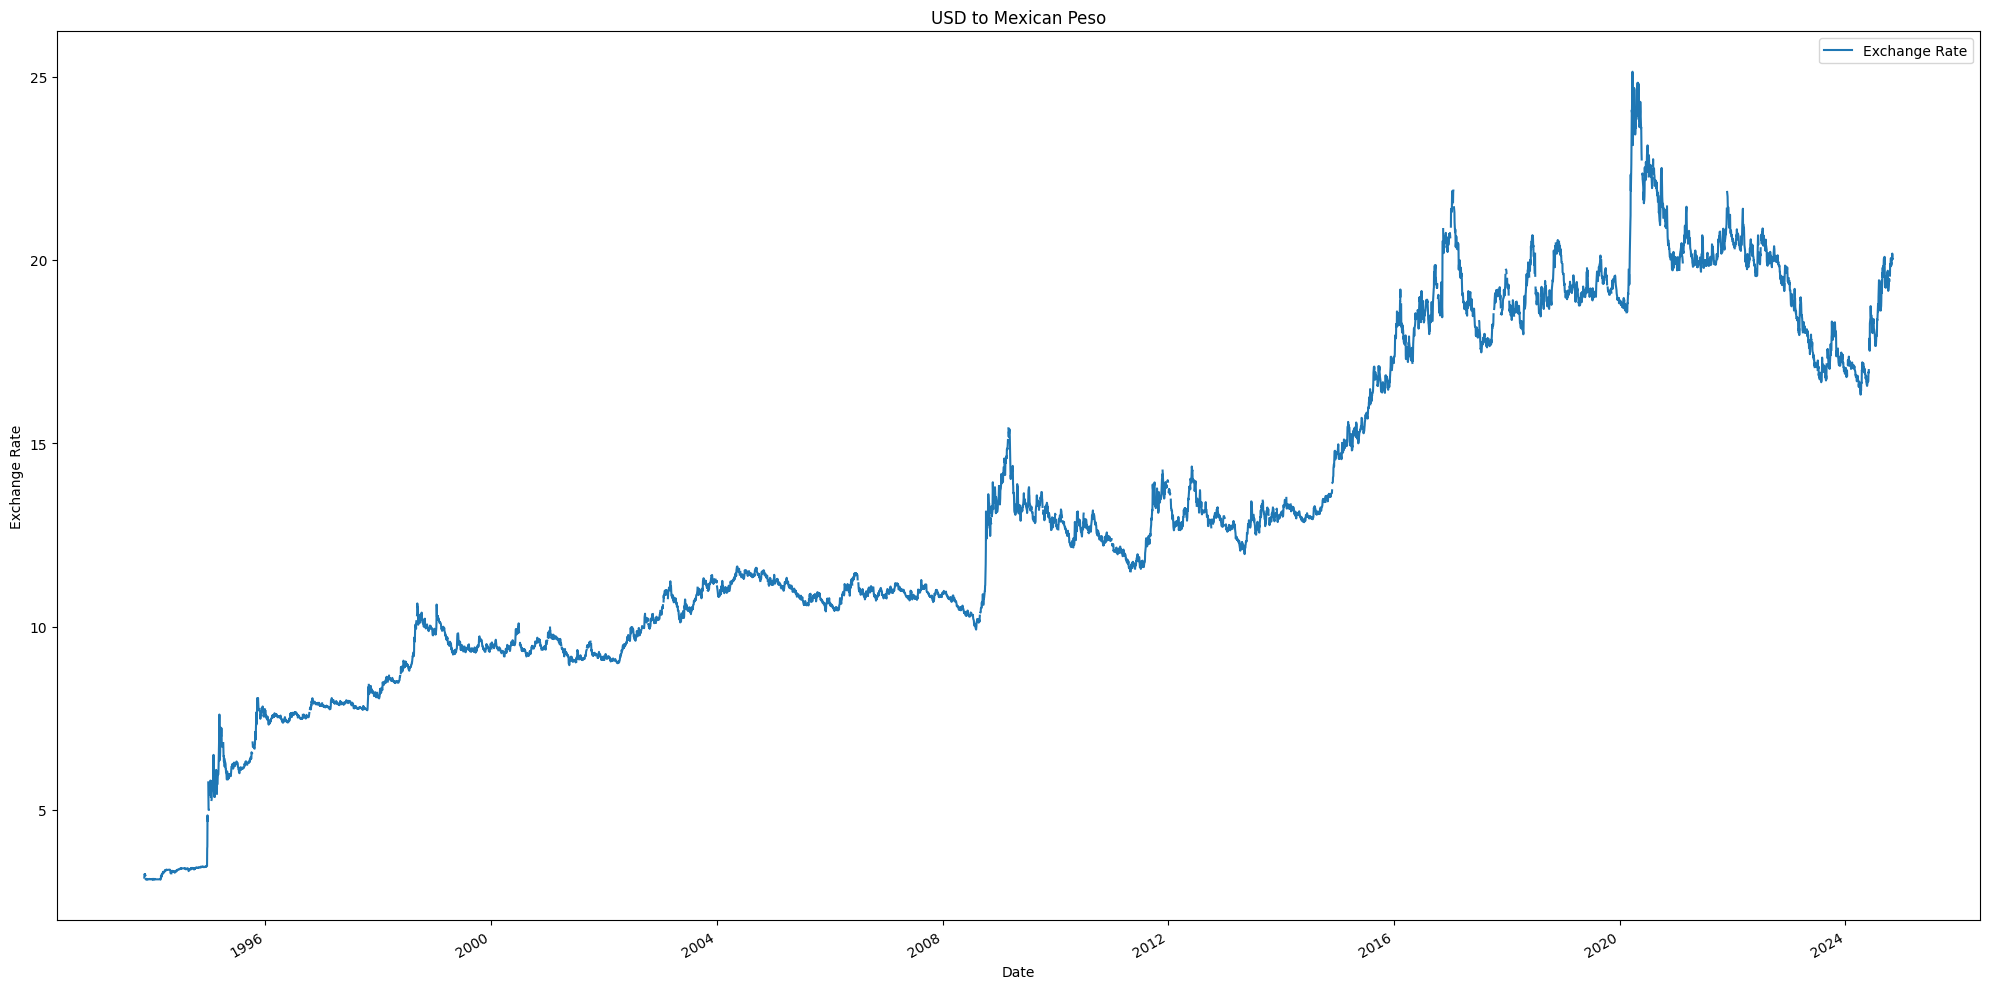

In [11]:
# Plot the Exchange Rate.  Provide title and label x and y-axis labels.
# When the USD to Peso exchange rate increases, the USD appreciates.
# When the USD to Peso exchange rate decreases, the USD depreciates.
# Note the time short time periods when USD appreciates dramaticlly.
# There is an upward trend in USD appreciation against the MXN in the
# past 30 years.

data_fx.plot(title='USD to Mexican Peso', figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.tight_layout()
plt.show()

### Calculate and plot regression line.

In [12]:
#Check type of Exchange Rate column
print(data_fx["Exchange Rate"].dtype)

float64


In [13]:
# drop null values
data_fx = data_fx.dropna()

In [14]:
# Calculate the y = mx +b line in above graph.  Show calculation and plot the regression line.
# already performed: from scipy import stats and import matplotlib.pyplot as plt

# Perform linear regression
# Convert the index to a numerical format
x = data_fx.index.map(pd.Timestamp.toordinal).values
y = data_fx["Exchange Rate"].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [15]:
# Calculate the predicted y values
regression_line = slope * x + intercept

dates = pd.to_datetime(data_fx.index)

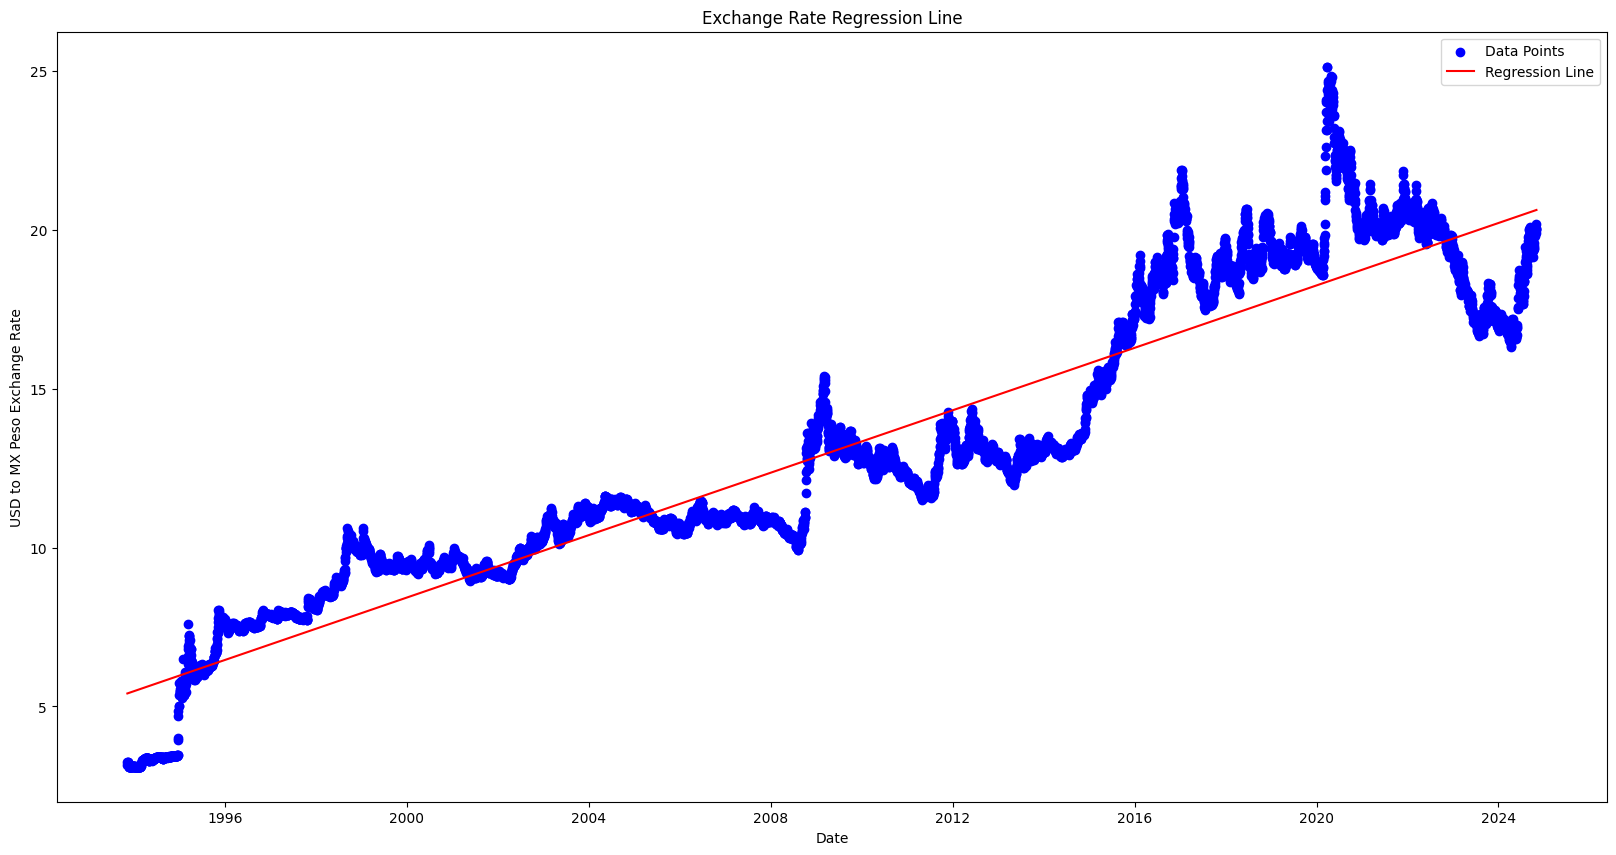

(0.001344618226416253, -973.3058387164346)

In [16]:
# Plotting
plt.figure(figsize=(20,10))
plt.scatter(data_fx.index, y, label="Data Points", color="blue")
plt.plot(data_fx.index, regression_line, color="red", label="Regression Line")
plt.xlabel("Date")
plt.ylabel("USD to MX Peso Exchange Rate")
plt.title("Exchange Rate Regression Line")
plt.legend()
plt.show()

#print slope and intercept values
slope, intercept



In [17]:
# This simple regression line is based on everything else the same.
# Convert the last day to ordinal
x_current = data_fx.index[-1].toordinal()

In [18]:
# Calculate the x value for 90 days later
x_90_days_later = x_current + 90

In [65]:
# Print the slope and intercept of the regression line
# Slope indicates the rate of change in the exchange rate per unit increase in time
print("Slope:", slope)

# Intercept is the value of the exchange rate when the independent variable (time) is zero
print("Intercept:", intercept)

# R-squared value (r_value**2) measures the proportion of variance in the exchange rate explained by time
# A higher R-squared value (closer to 1) indicates a better fit of the model to the data
print("R-squared:", r_value**2)

# P-value tests the null hypothesis that the slope is zero (no relationship between x and y)
# A low p-value (typically < 0.05) suggests that the slope is statistically significant
print("P-value:", p_value)

# Standard error measures the precision of the slope estimate
# A lower standard error indicates a more precise estimate of the slope
print("Standard error:", std_err)


Slope: 0.001344618226416253
Intercept: -4.291123178313798
R-squared: 0.8825867571899069
P-value: 0.0
Standard error: 5.564475357628708e-06


In [20]:
# Calculate the predicted y value (USD to MXN foreign exchange rate)
predicted_y = slope * x_90_days_later + intercept


In [21]:
# Cannot be negataive number
print(f"Predicted value in 90 days: {predicted_y}")

Predicted value in 90 days: 20.744868326799406


### The USD is considered a safe haven during times of economic turmoil.


<ipython-input-22-0f6130d24f47>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fx.loc[row_date, '1_year_avg'] = avg
<ipython-input-22-0f6130d24f47>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fx.loc[row_date, '2_std_upper'] = avg + 2 * std
<ipython-input-22-0f6130d24f47>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

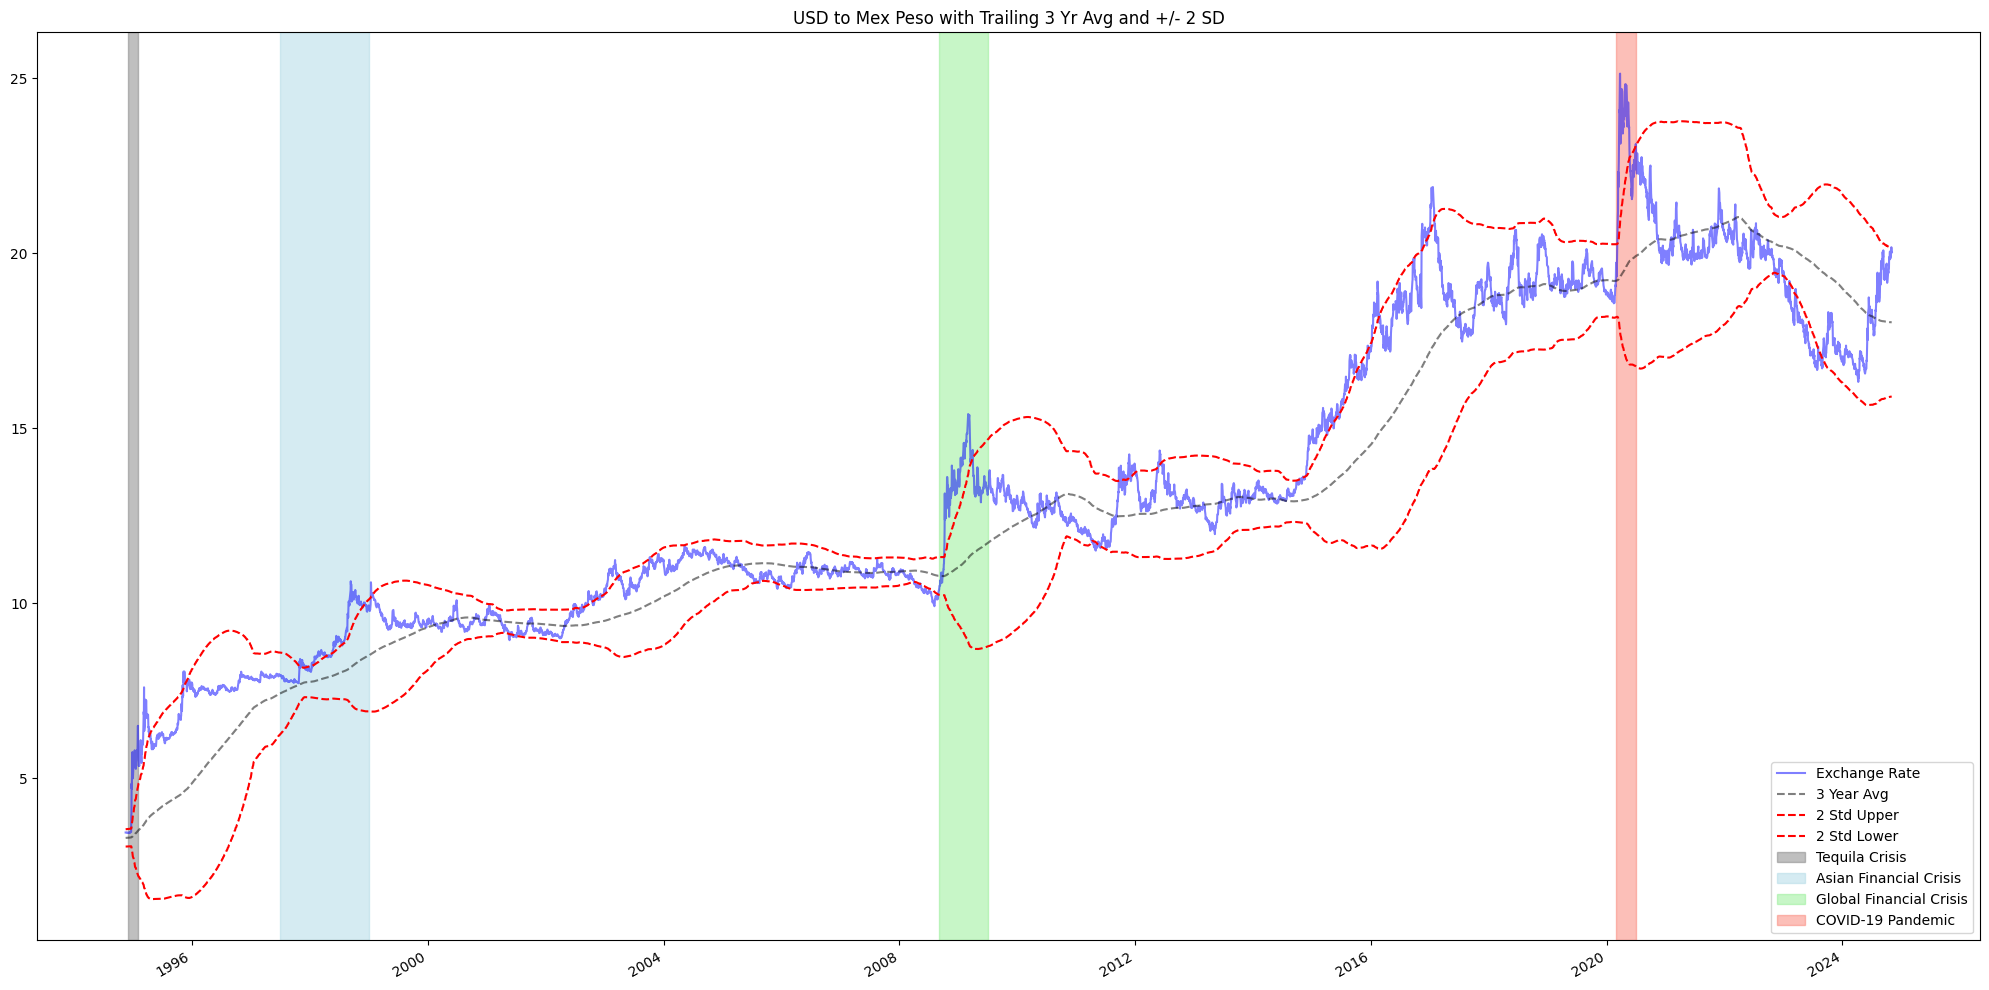

In [22]:
# for loop for each row, set start_date 756 days or 3 years back.
# if data_3_year retrieves 3 years data
# need to adjust if any data is NaN
# Create the average and +/- 2 SD (standard deviation)

plt.figure(figsize=(20, 10))

for row_date in data_fx.index:
    start_date = row_date - pd.DateOffset(days=756)  # Look back 756 days
    data_3_year = data_fx.loc[start_date:row_date, 'Exchange Rate']

    # why not return False or empty for the first three years
    if not data_3_year.empty:
        avg = data_3_year.mean()
        std = data_3_year.std()

        # Assign the computed values using loc
        data_fx.loc[row_date, '1_year_avg'] = avg
        data_fx.loc[row_date, '2_std_upper'] = avg + 2 * std
        data_fx.loc[row_date, '2_std_lower'] = avg - 2 * std

# Filter data to remove empty rows from the first three years.
filtered_data = data_fx.dropna(subset=['1_year_avg', '2_std_upper', '2_std_lower'])

# For 3 year trailing average, forward 3 years or 756 days
filtered_data = data_fx[data_fx.index >= data_fx.index[251]]

# Filter for dates starting from 1997 - Need to verify
#filtered_data = filtered_data[filtered_data.index >= pd.Timestamp('1997-01-01')]

# Plotting: calculate current, 3 year moving average, and +/- 2 SD
filtered_data['Exchange Rate'].plot(label='Exchange Rate', color='blue', alpha=0.5)
filtered_data['1_year_avg'].plot(label='3 Year Avg', color='black', linestyle="--", alpha=0.5)
filtered_data['2_std_upper'].plot(label='2 Std Upper', color='red', linestyle='--')
filtered_data['2_std_lower'].plot(label='2 Std Lower', color='red', linestyle='--')

# Major economic events effecting USD to MXN exchanage rate
plt.axvspan(pd.Timestamp('1994-12-01'), pd.Timestamp('1995-01-31'), color='grey', alpha=0.5, label='Tequila Crisis')
plt.axvspan(pd.Timestamp('1997-07-01'), pd.Timestamp('1998-12-31'), color='lightblue', alpha=0.5, label='Asian Financial Crisis')
plt.axvspan(pd.Timestamp('2008-09-01'), pd.Timestamp('2009-06-30'), color='lightgreen', alpha=0.5, label='Global Financial Crisis')
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-30'), color='salmon', alpha=0.5, label='COVID-19 Pandemic')

 # Label and plot
# plt.figure(figsize=(20, 10))
plt.title('USD to Mex Peso with Trailing 3 Yr Avg and +/- 2 SD')
plt.legend()
plt.tight_layout()
plt.show()

# If all the code in one panel or cell, it works.
# How to fix this problem

### Correlation

In [23]:
# display some of the rows from the main data dataframe
data

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP,US CPI,MX CPI,US Unemployment,MX Unemployment,Oil Price
1934-01-01,NaN,NaN,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-02-01,NaN,NaN,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-03-01,NaN,NaN,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-04-01,NaN,NaN,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-05-01,NaN,NaN,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-29,20.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.48
2024-10-30,20.1720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.91
2024-10-31,20.0314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.58
2024-11-01,20.0273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.81


In [24]:
# Calculate quarterly mean values
quarterly_avg = data.resample('Q').mean()
quarterly_avg

<ipython-input-24-5001cdf47196>:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = data.resample('Q').mean()


,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP,US CPI,MX CPI,US Unemployment,MX Unemployment,Oil Price
1934-03-31,NaN,NaN,0.526667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-06-30,NaN,NaN,0.153333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-09-30,NaN,NaN,0.183333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-12-31,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1935-03-31,NaN,NaN,0.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,17.545556,5.330000,5.283333,11.060000,22960.600,6300104.5,308.099000,149.992967,3.733333,NaN,78.526721
2024-03-31,16.983616,5.330000,5.233333,11.120000,23053.545,6306870.5,310.989667,152.607000,3.800000,NaN,77.503934
2024-06-30,17.222032,5.330000,5.243333,10.976667,23223.906,6316702.0,313.160333,153.259567,4.000000,NaN,81.805714
2024-09-30,18.924516,5.263333,4.990000,10.840000,23386.248,NaN,314.113667,155.157900,4.200000,NaN,76.427500


In [25]:
# Drop null values
quarterly_avg.dropna(inplace=True)
quarterly_avg

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP,US CPI,MX CPI,US Unemployment,MX Unemployment,Oil Price
2005-03-31,11.184419,2.470000,2.536667,9.053333,15844.727,4687957.0,192.366667,66.769560,5.300000,3.677891,49.896393
2006-03-31,10.601253,4.456667,4.393333,7.620000,16353.835,4917909.0,199.466667,69.238640,4.733333,3.681194,63.265323
2007-03-31,11.024155,5.256667,4.983333,7.040000,16611.690,5025603.5,204.317000,72.077503,4.500000,3.765687,58.075000
2008-03-31,10.802661,3.176667,2.043333,7.426667,16843.003,5091017.5,212.769667,74.883067,5.000000,4.030118,97.855410
2009-03-31,14.384074,0.183333,0.213333,7.246667,16298.262,4736663.0,212.377667,79.507393,8.266667,5.558005,43.139672
2010-03-31,12.758708,0.133333,0.106667,4.476667,16582.710,4951693.5,217.374000,83.286570,9.833333,5.506372,78.807049
2011-03-31,12.059774,0.156667,0.126667,4.150000,16920.632,5129689.5,222.043667,86.170790,9.033333,5.366127,94.066129
2012-03-31,12.965690,0.103333,0.066667,4.276667,17367.010,5332265.5,228.326000,89.515300,8.266667,5.084452,102.984194
2013-03-31,12.637628,0.143333,0.086667,4.106667,17662.400,5426441.5,232.299333,92.815530,7.733333,5.104861,94.325500
2014-03-31,13.234033,0.073333,0.046667,3.156667,17953.974,5499415.0,235.621000,96.673987,6.666667,5.002806,98.678197


In [64]:
quarterly_avg.shape
quarterly_avg.head()

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP,US CPI,MX CPI,US Unemployment,MX Unemployment,Oil Price
2005-03-31,11.184419,2.470000,2.536667,9.053333,15844.727,4687957.0,192.366667,66.769560,5.300000,3.677891,49.896393
2006-03-31,10.601253,4.456667,4.393333,7.620000,16353.835,4917909.0,199.466667,69.238640,4.733333,3.681194,63.265323
2007-03-31,11.024155,5.256667,4.983333,7.040000,16611.690,5025603.5,204.317000,72.077503,4.500000,3.765687,58.075000
2008-03-31,10.802661,3.176667,2.043333,7.426667,16843.003,5091017.5,212.769667,74.883067,5.000000,4.030118,97.855410
2009-03-31,14.384074,0.183333,0.213333,7.246667,16298.262,4736663.0,212.377667,79.507393,8.266667,5.558005,43.139672


In [26]:
# Create a correlation matrix
correlation_matrix = quarterly_avg.corr()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(correlation_matrix)

                  Exchange Rate  Fed Rate  US 90-Day T-bill  MX 90-Day T-bill  US Real GDP  MX Real GDP    US CPI    MX CPI  US Unemployment  MX Unemployment  Oil Price
Exchange Rate          1.000000 -0.265990         -0.209552          0.040074     0.899183     0.867507  0.831532  0.887773        -0.460545        -0.456477  -0.292626
Fed Rate              -0.265990  1.000000          0.988077          0.756273    -0.066136    -0.121364 -0.137175 -0.164132        -0.567142        -0.619229  -0.135987
US 90-Day T-bill      -0.209552  0.988077          1.000000          0.778230    -0.013699    -0.080433 -0.084126 -0.104535        -0.579354        -0.644142  -0.174901
MX 90-Day T-bill       0.040074  0.756273          0.778230          1.000000     0.132240    -0.001476  0.092407  0.078676        -0.531097        -0.635251  -0.174303
US Real GDP            0.899183 -0.066136         -0.013699          0.132240     1.000000     0.938855  0.968422  0.985534        -0.559079        -0.5668

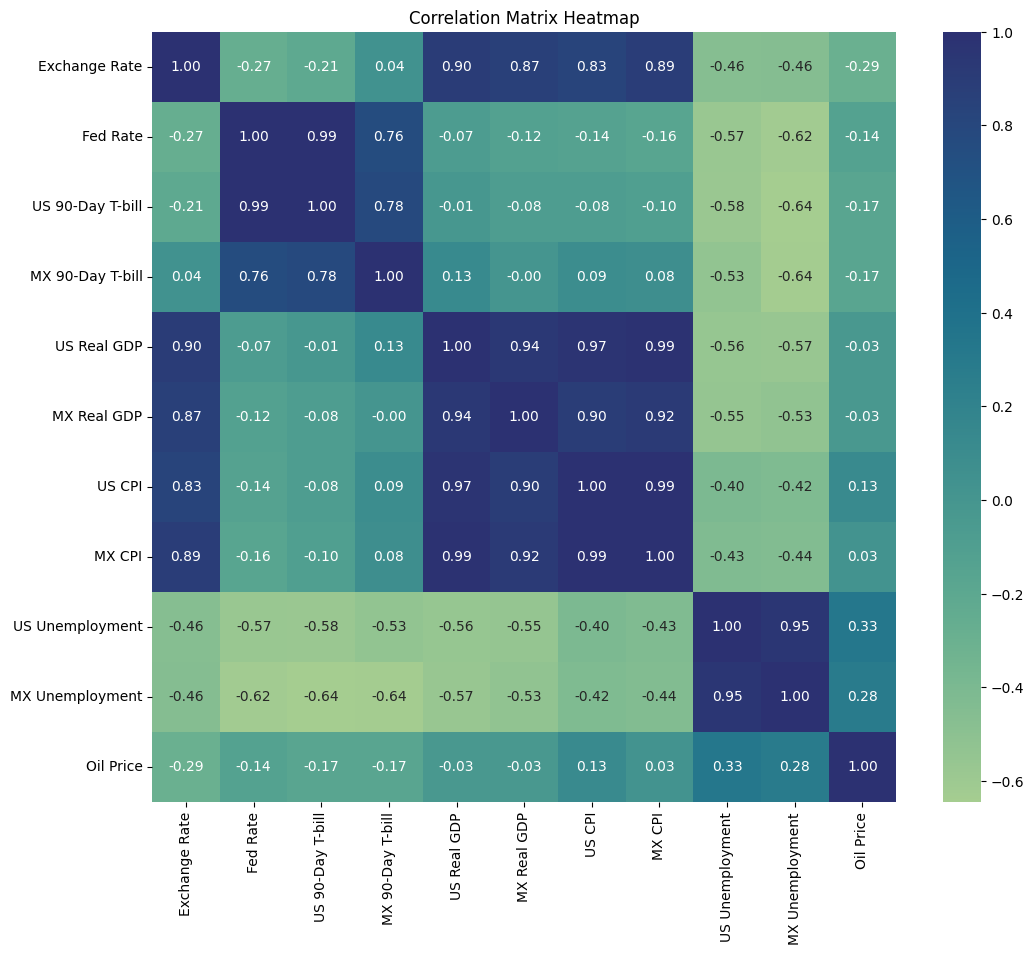

In [27]:
# Generate the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

From the heatmap, you can see a strong corrlation between the exchange rate and the GDP of both countries as well as the inflation of both countries

In [28]:
print(data_fx.columns)


Index(['Exchange Rate', '1_year_avg', '2_std_upper', '2_std_lower'], dtype='object')


Multivariate Linear Regression Equation:
Exchange Rate = -4.2911 + (-0.4829 * Fed Rate) + (0.0017 * US Real GDP) + (0.0000 * MX Real GDP) + (-0.0733 * US CPI) + (0.0719 * MX CPI) + (-0.0389 * Oil Price)


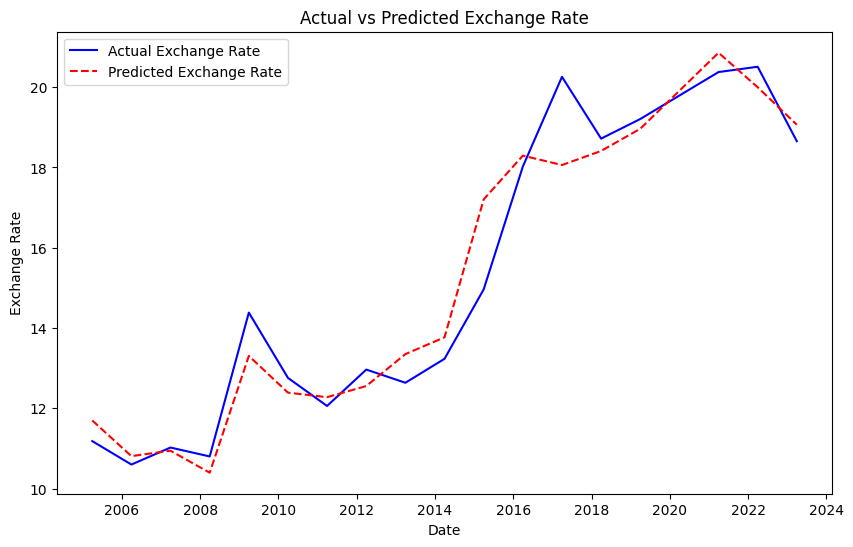

In [29]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define the features based on high correlation with "Exchange Rate"
features = ["Fed Rate", "US Real GDP", "MX Real GDP", "US CPI", "MX CPI", "Oil Price"]
X = quarterly_avg[features]  # Independent variables
y = quarterly_avg["Exchange Rate"]  # Dependent variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and intercept to form the regression equation
coefficients = model.coef_
intercept = model.intercept_

# Display the regression equation
print("Multivariate Linear Regression Equation:")
equation = "Exchange Rate = {:.4f}".format(intercept)
for i, feature in enumerate(features):
    equation += " + ({:.4f} * {})".format(coefficients[i], feature)
print(equation)

# Predict the Exchange Rate values using the model
predicted_exchange_rate = model.predict(X)

# Plot actual vs predicted Exchange Rate values over time
dates = pd.to_datetime(quarterly_avg.index)  # Convert index to datetime for plotting

plt.figure(figsize=(10, 6))
plt.plot(dates, y, label="Actual Exchange Rate", color="blue")
plt.plot(dates, predicted_exchange_rate, label="Predicted Exchange Rate", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Actual vs Predicted Exchange Rate")
plt.legend()
plt.show()




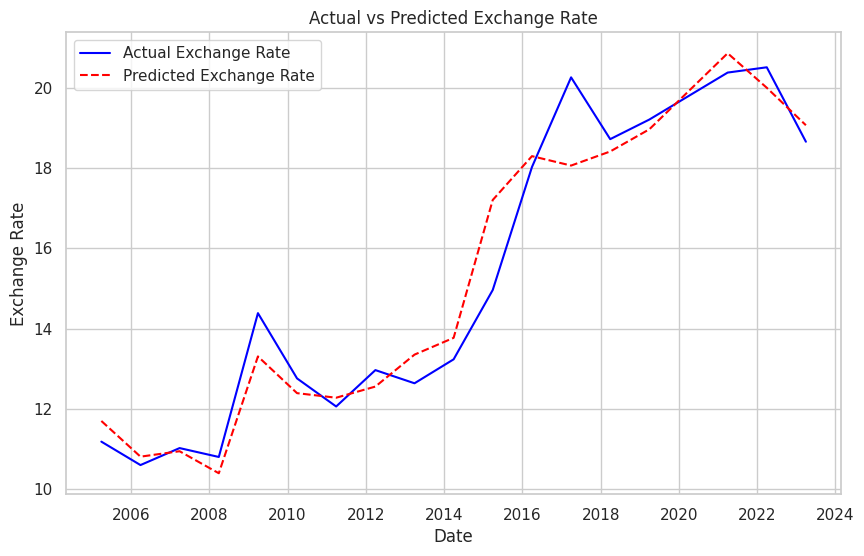

In [30]:
import seaborn as sns

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the Seaborn plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=dates, y=y, label="Actual Exchange Rate", color="blue")
sns.lineplot(x=dates, y=predicted_exchange_rate, label="Predicted Exchange Rate", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Actual vs Predicted Exchange Rate")
plt.legend()
plt.show()


In [31]:
import plotly.graph_objects as go

# Create the plotly figure
fig = go.Figure()

# Add actual exchange rate line
fig.add_trace(go.Scatter(
    x=dates, y=y, mode='lines', name='Actual Exchange Rate', line=dict(color='blue')
))

# Add predicted exchange rate line
fig.add_trace(go.Scatter(
    x=dates, y=predicted_exchange_rate, mode='lines', name='Predicted Exchange Rate', line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title="Actual vs Predicted Exchange Rate",
    xaxis_title="Date",
    yaxis_title="Exchange Rate",
    template="plotly_white"
)

# Display the interactive plot
fig.show()


### Interest Rate Parity (IRP). F = S x (1 + i US)/(1 + i MX).  
##### F is forward exchange rate, S is spot exchange rate (current), i US
##### is US 90 day T-bill and i MX is Mexico 90 day T-bill.
##### Example: F = 18 x (1.02) / (1.05) = 17.78
##### Everything else the same, the USD will depreciate vs MXN.

In [32]:
# Create a new DataFrame from the 'mother' DataFrame.  Use new variable.
data_irp = data[['Exchange Rate', 'US 90-Day T-bill', 'MX 90-Day T-bill']]

In [33]:
# US 90-Day T-bill is daily close; MX 90-Day T-bill is monthly average.
# Therefore, use quarterly average df.resample().mean()
monthly_avg_irp = data_irp.resample('M').mean()
monthly_avg_irp.dropna(inplace=True)
monthly_avg_irp

<ipython-input-33-39cd4411d1ad>:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,Exchange Rate,US 90-Day T-bill,MX 90-Day T-bill
1993-11-30,3.149792,3.10,14.38
1993-12-31,3.108314,3.06,11.78
1994-01-31,3.107785,2.98,10.52
1994-02-28,3.121763,3.25,9.45
1994-03-31,3.302632,3.50,9.73
...,...,...,...
2024-04-30,16.800809,5.24,10.97
2024-05-31,16.803277,5.25,10.99
2024-06-30,18.194637,5.24,10.97
2024-07-31,18.100173,5.20,10.92


In [34]:
# Add a new column for "Forward 90 Day Rate"
monthly_avg_irp["Forward 90 Day Rate"] = monthly_avg_irp["Exchange Rate"] * \
                            ( 1 + monthly_avg_irp["US 90-Day T-bill"]/4/100) \
                            / (1 + monthly_avg_irp["MX 90-Day T-bill"]/4/100)

In [35]:
# Display data
monthly_avg_irp

,Exchange Rate,US 90-Day T-bill,MX 90-Day T-bill,Forward 90 Day Rate
1993-11-30,3.149792,3.10,14.38,3.064051
1993-12-31,3.108314,3.06,11.78,3.042491
1994-01-31,3.107785,2.98,10.52,3.050704
1994-02-28,3.121763,3.25,9.45,3.074493
1994-03-31,3.302632,3.50,9.73,3.252415
...,...,...,...,...
2024-04-30,16.800809,5.24,10.97,16.566562
2024-05-31,16.803277,5.25,10.99,16.568598
2024-06-30,18.194637,5.24,10.97,17.940956
2024-07-31,18.100173,5.20,10.92,17.848219


In [36]:
# Shift Forward 90 Day Rate 3 period forward or 90 days.
monthly_avg_irp["Forward 90 Day Rate Shifted"] = monthly_avg_irp["Forward 90 Day Rate"].shift(3)

In [37]:
# Show changes of shift
monthly_avg_irp

,Exchange Rate,US 90-Day T-bill,MX 90-Day T-bill,Forward 90 Day Rate,Forward 90 Day Rate Shifted
1993-11-30,3.149792,3.10,14.38,3.064051,NaN
1993-12-31,3.108314,3.06,11.78,3.042491,NaN
1994-01-31,3.107785,2.98,10.52,3.050704,NaN
1994-02-28,3.121763,3.25,9.45,3.074493,3.064051
1994-03-31,3.302632,3.50,9.73,3.252415,3.042491
...,...,...,...,...,...
2024-04-30,16.800809,5.24,10.97,16.566562,16.840889
2024-05-31,16.803277,5.25,10.99,16.568598,16.852049
2024-06-30,18.194637,5.24,10.97,17.940956,16.533452
2024-07-31,18.100173,5.20,10.92,17.848219,16.566562


In [38]:
# Calculate correlation matrix for only the "Exchange Rate" and "Forward 90 Day Rate" columns
correlation = monthly_avg_irp[['Exchange Rate', 'Forward 90 Day Rate Shifted']].corr()

# Display the correlation matrix
print(correlation)

                             Exchange Rate  Forward 90 Day Rate Shifted
Exchange Rate                     1.000000                     0.984506
Forward 90 Day Rate Shifted       0.984506                     1.000000


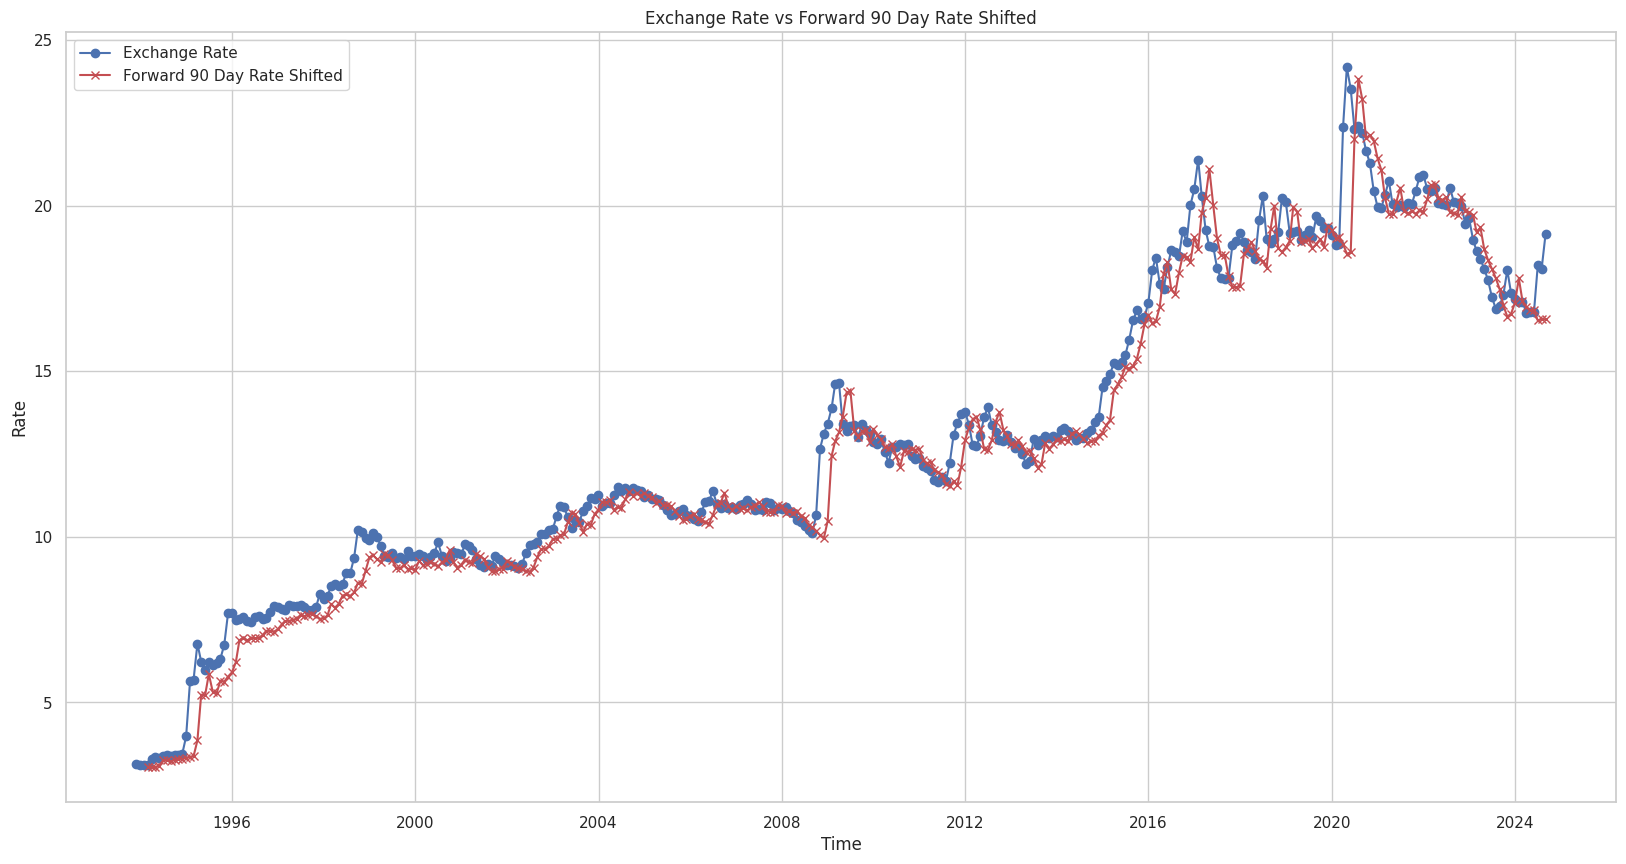

In [39]:
# Create the plot
plt.figure(figsize=(20, 10))  # Set the size of the plot

# Plot Exchange Rate
plt.plot(monthly_avg_irp.index, monthly_avg_irp['Exchange Rate'], label='Exchange Rate', marker='o', linestyle='-', color='b')

# Plot Forward 90 Day Rate Shifted
plt.plot(monthly_avg_irp.index, monthly_avg_irp['Forward 90 Day Rate Shifted'], label='Forward 90 Day Rate Shifted', marker='x', linestyle='-', color='r')

# Add labels and a title
plt.xlabel('Time')  # Label for x-axis
plt.ylabel('Rate')  # Label for y-axis
plt.title('Exchange Rate vs Forward 90 Day Rate Shifted')  # Title for the graph

# Add a legend to differentiate the lines
plt.legend()

# Optionally, add a grid for better visualization
plt.grid(True)

# Display the plot
plt.show()

### Prophet

In [40]:
# Check the shape of the data_fx dataframe
data_fx.shape

(7770, 4)

In [41]:
# Look at the last five rows in the dataframe
data_fx.tail()

,Exchange Rate,1_year_avg,2_std_upper,2_std_lower
2024-10-28,20.0444,18.028770,20.154769,15.902772
2024-10-29,20.0000,18.028707,20.154466,15.902947
2024-10-30,20.1720,18.029097,20.156357,15.901836
2024-10-31,20.0314,18.028951,20.155650,15.902251
2024-11-01,20.0273,18.028789,20.154867,15.902711


In [42]:
# Look at data_fx dataframe info
data_fx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7770 entries, 1993-11-08 to 2024-11-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Exchange Rate  7770 non-null   float64
 1   1_year_avg     7770 non-null   float64
 2   2_std_upper    7769 non-null   float64
 3   2_std_lower    7769 non-null   float64
dtypes: float64(4)
memory usage: 561.6 KB


In [43]:
# Create datframe with just Exchange Rate for use with Prophet
data_fx_for_prophet = data_fx['Exchange Rate']

In [44]:
# Display shape and info for new data_fx_for_prophet dataframe
display(data_fx_for_prophet.shape)
display(data_fx_for_prophet.info())

(7770,)

<class 'pandas.core.series.Series'>
DatetimeIndex: 7770 entries, 1993-11-08 to 2024-11-01
Series name: Exchange Rate
Non-Null Count  Dtype  
--------------  -----  
7770 non-null   float64
dtypes: float64(1)
memory usage: 379.4 KB


None

There are no null values in the dataframe

In [45]:
# Reset index so that date is no longer in the index and is in a column
data_fx_for_prophet = data_fx_for_prophet.reset_index()

In [46]:
# Look at the last 5 rows in the dataframe to see the new column
data_fx_for_prophet.head()

,index,Exchange Rate
0,1993-11-08,3.152
1,1993-11-09,3.240
2,1993-11-10,3.240
3,1993-11-12,3.240
4,1993-11-15,3.215


In [47]:
# rename columns as required by Prophet
data_fx_for_prophet.columns = ['ds', 'y']

In [48]:
# Look at shape, first five rows and last five rows of dataframe
display(data_fx_for_prophet.shape)
display(data_fx_for_prophet.head())
display(data_fx_for_prophet.tail())

(7770, 2)

,ds,y
0,1993-11-08,3.152
1,1993-11-09,3.240
2,1993-11-10,3.240
3,1993-11-12,3.240
4,1993-11-15,3.215


,ds,y
7765,2024-10-28,20.0444
7766,2024-10-29,20.0000
7767,2024-10-30,20.1720
7768,2024-10-31,20.0314
7769,2024-11-01,20.0273


In [49]:
#Call the Prophet function, and store in a variable
model = Prophet()
model

In [50]:
# Fit the prophet model
model.fit(data_fx_for_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeg3mj4x2/_8f9jka3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeg3mj4x2/rnh5m7ss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82839', 'data', 'file=/tmp/tmpeg3mj4x2/_8f9jka3.json', 'init=/tmp/tmpeg3mj4x2/rnh5m7ss.json', 'output', 'file=/tmp/tmpeg3mj4x2/prophet_model7puraru2/prophet_model-20241111165219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [51]:
# Create a future dataframe to hold predictions
# Make the predictions go out as far as 70 business days.  This is approx 3 months out.
future_trends = model.make_future_dataframe(periods=70, freq="B")

# Look at last 20 rows - verfiy that weekends are not included
future_trends.tail(20)

,ds
7820,2025-01-13
7821,2025-01-14
7822,2025-01-15
7823,2025-01-16
7824,2025-01-17
7825,2025-01-20
7826,2025-01-21
7827,2025-01-22
7828,2025-01-23
7829,2025-01-24


In [52]:
# Make the predictions for the trend data using the future trends DataFrame
forecast_trends = model.predict(future_trends)

# Display the first five rows of the forecast dataframe
forecast_trends.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7835,2025-02-03,18.491230,17.447898,19.469790,18.483230,18.499289,-0.059505,-0.059505,-0.059505,-0.137743,-0.137743,-0.137743,0.078238,0.078238,0.078238,0.0,0.0,0.0,18.431725
7836,2025-02-04,18.490348,17.361120,19.348769,18.483412,18.498845,-0.062270,-0.062270,-0.062270,-0.136663,-0.136663,-0.136663,0.074393,0.074393,0.074393,0.0,0.0,0.0,18.428078
7837,2025-02-05,18.489466,17.387476,19.396925,18.482715,18.498440,-0.064850,-0.064850,-0.064850,-0.135132,-0.135132,-0.135132,0.070283,0.070283,0.070283,0.0,0.0,0.0,18.424616
7838,2025-02-06,18.488583,17.410351,19.400704,18.481401,18.499819,-0.068134,-0.068134,-0.068134,-0.134111,-0.134111,-0.134111,0.065977,0.065977,0.065977,0.0,0.0,0.0,18.420449
7839,2025-02-07,18.487701,17.381426,19.485870,18.477534,18.499343,-0.083402,-0.083402,-0.083402,-0.144958,-0.144958,-0.144958,0.061556,0.061556,0.061556,0.0,0.0,0.0,18.404299


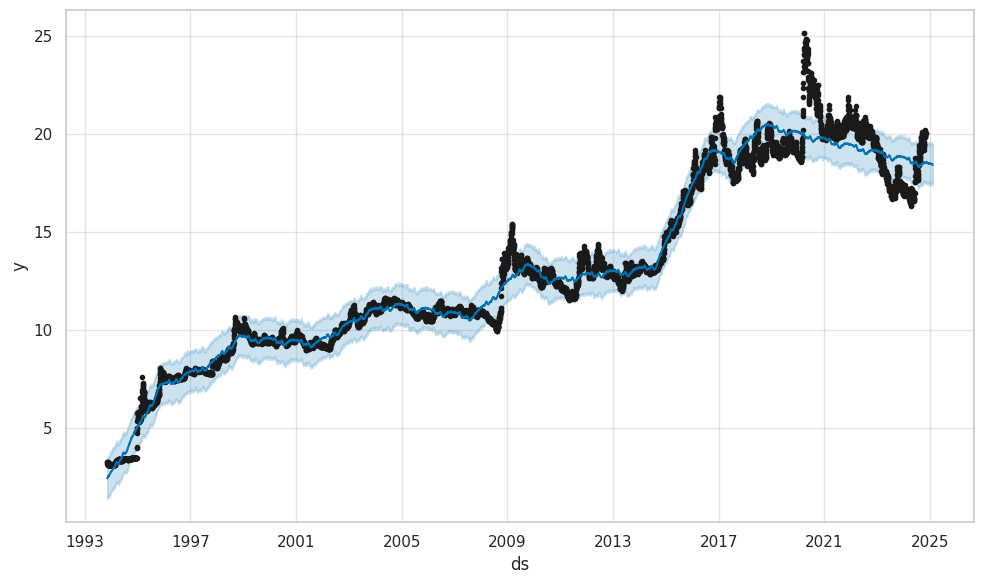

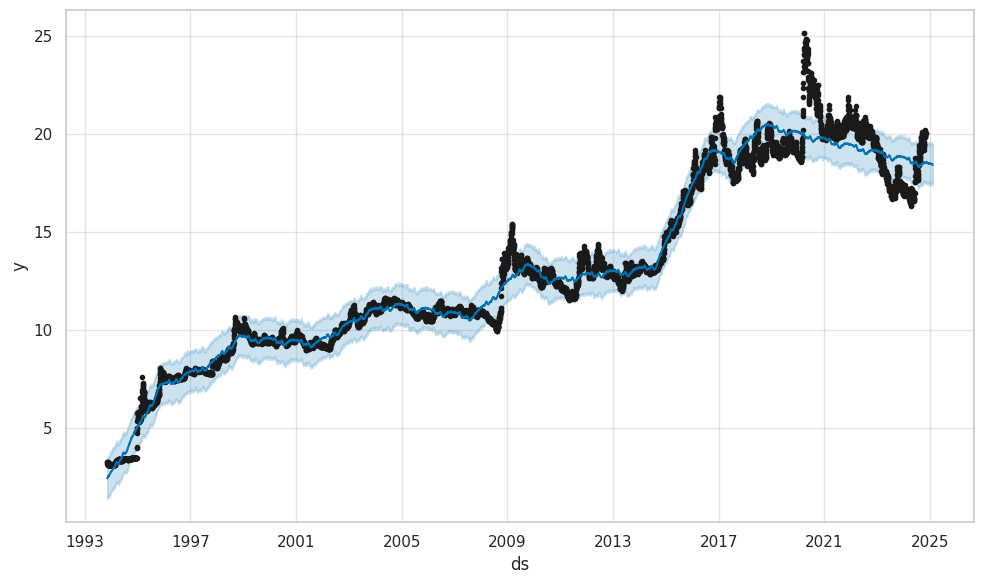

In [53]:
# Plot the Prophet predictions
model.plot(forecast_trends)

In [54]:
#Look at first five rows of forecast_trends dataframe
forecast_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1993-11-08,2.441227,1.381726,3.406445,2.441227,2.441227,-0.038989,-0.038989,-0.038989,-0.137743,-0.137743,-0.137743,0.098754,0.098754,0.098754,0.0,0.0,0.0,2.402238
1,1993-11-09,2.447441,1.355848,3.385287,2.447441,2.447441,-0.034061,-0.034061,-0.034061,-0.136663,-0.136663,-0.136663,0.102602,0.102602,0.102602,0.0,0.0,0.0,2.413379
2,1993-11-10,2.453655,1.354366,3.394846,2.453655,2.453655,-0.028858,-0.028858,-0.028858,-0.135132,-0.135132,-0.135132,0.106274,0.106274,0.106274,0.0,0.0,0.0,2.424797
3,1993-11-12,2.466082,1.350720,3.459161,2.466082,2.466082,-0.032184,-0.032184,-0.032184,-0.144958,-0.144958,-0.144958,0.112774,0.112774,0.112774,0.0,0.0,0.0,2.433898
4,1993-11-15,2.484723,1.470601,3.483467,2.484723,2.484723,-0.018330,-0.018330,-0.018330,-0.137743,-0.137743,-0.137743,0.119413,0.119413,0.119413,0.0,0.0,0.0,2.466393


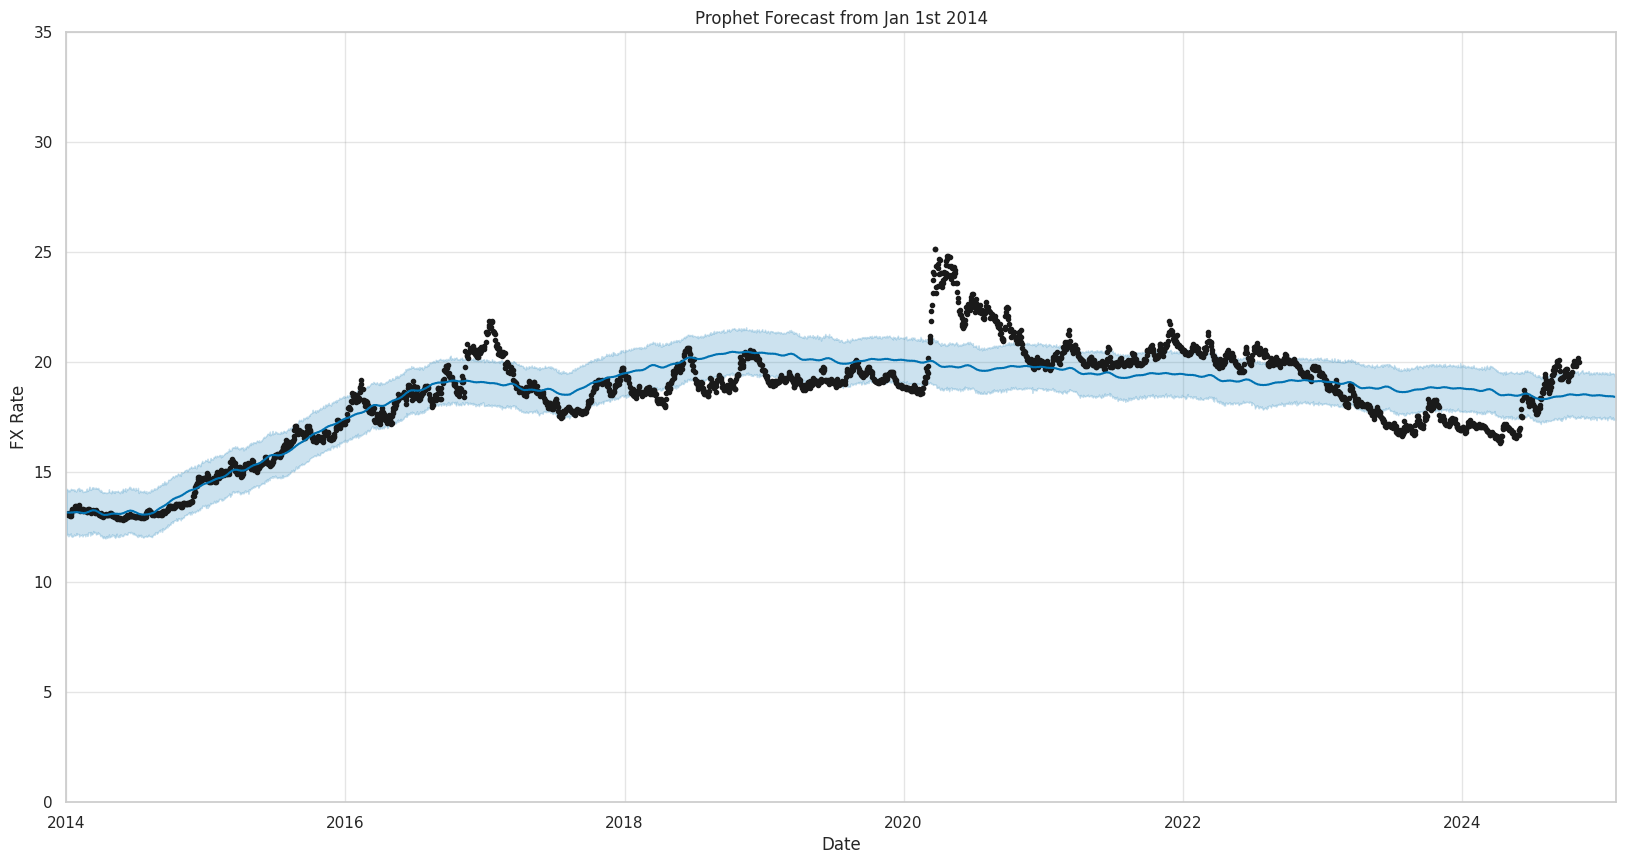

In [55]:
# Create a chart with a 10 year history to see whether it could be used as one of our final charts

# Create dataframe with data from begin Jan 2014
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2014-01-01']

# Calculate / Specify start and end dates
start_date = mdates.datestr2num('2014-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

# Plot subplots
fig, ax = plt.subplots(figsize=(20, 10))

#Plot chart
model.plot(filtered_forecast, ax=ax)

#Set X, Y labels and Title
ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2014')

#Set X and Y limits
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)

#Show plot
plt.show()

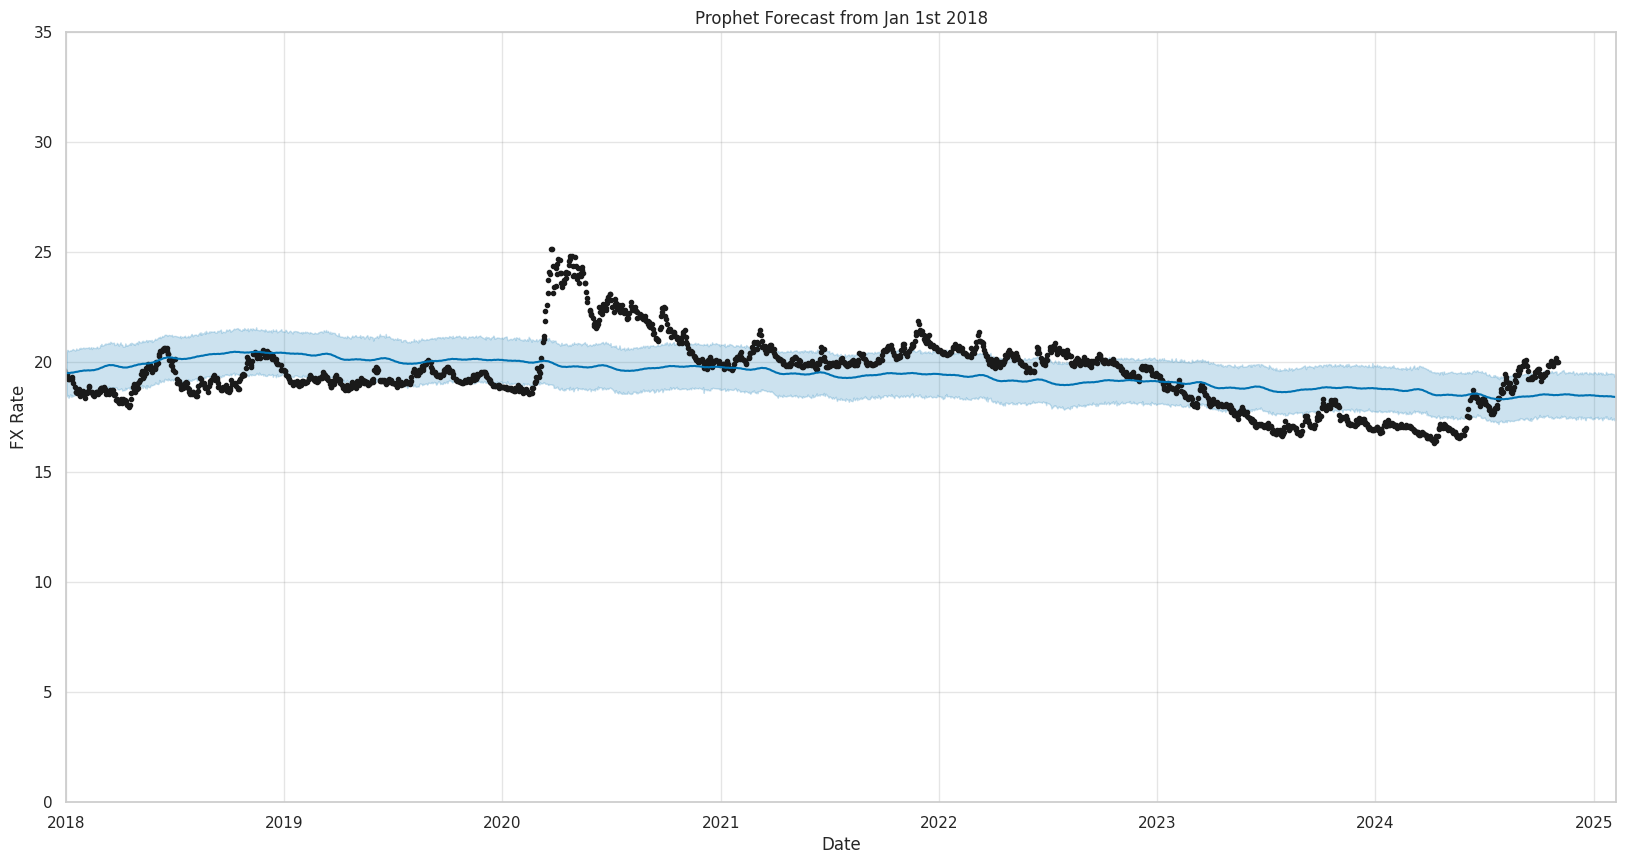

In [56]:
# Create a chart with a 7 year history to see whether it could be used as one of our final charts

# Create dataframe with data from begin Jan 2018
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2018-01-01']

# Calculate / Specify start and end dates
start_date = mdates.datestr2num('2018-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

# Plot subplots
fig, ax = plt.subplots(figsize=(20, 10))

#Plot chart
model.plot(filtered_forecast, ax=ax)

#Set X, Y labels and Title
ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2018')

#Set X and Y limits
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)

#Show plot
plt.show()

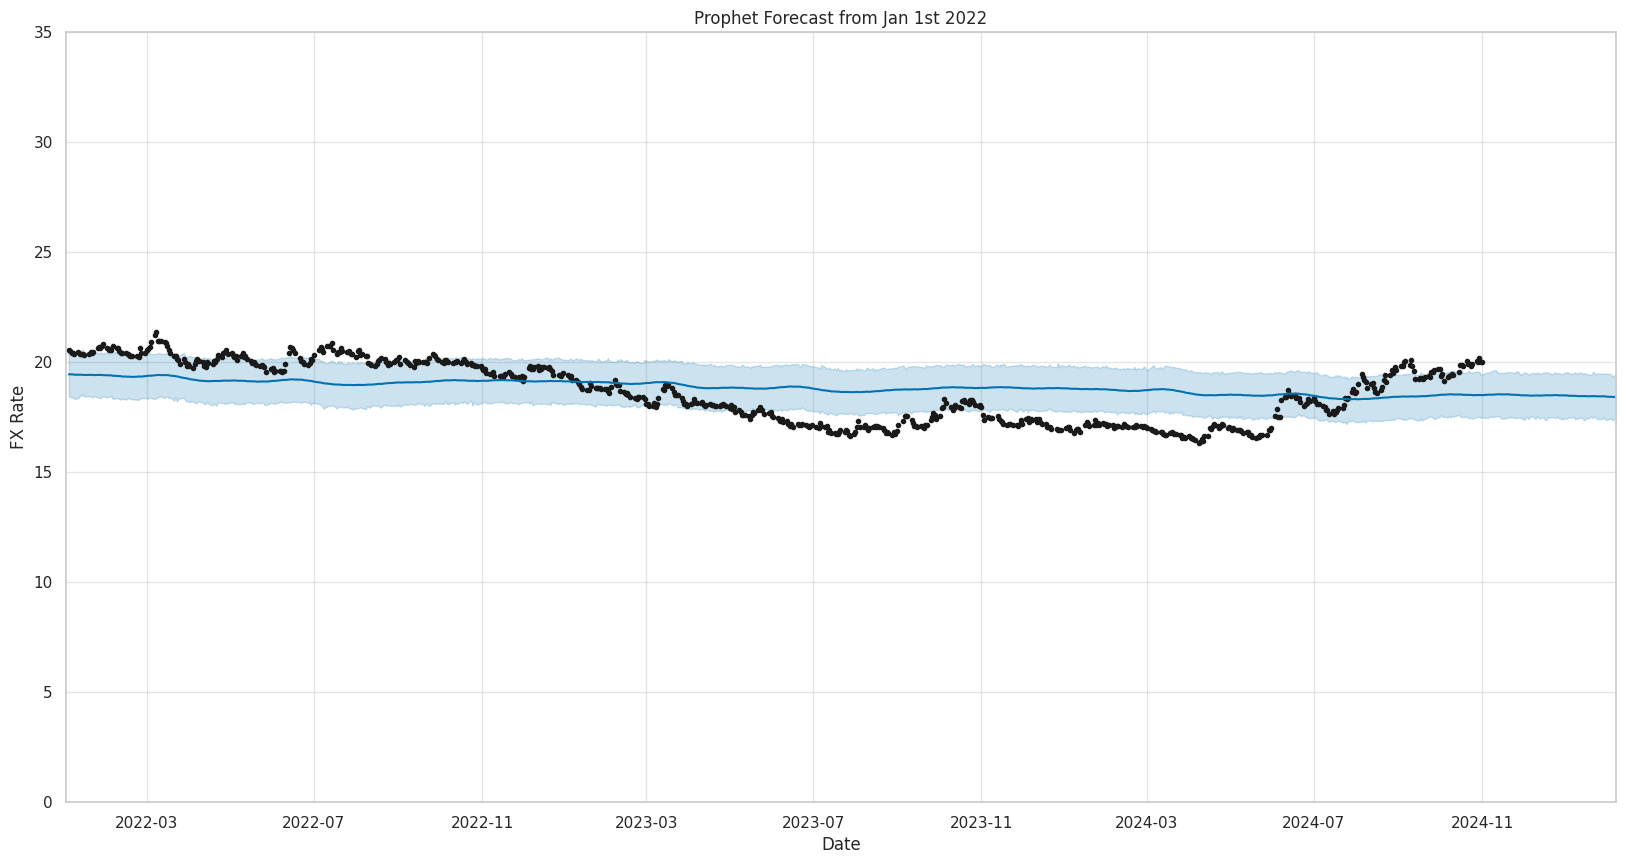

In [57]:
# Create a chart with a 3 year history to see whether it could be used as one of our final charts

# Create dataframe with data from begin Jan 2022
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2022-01-01']

# Calculate / Specify start and end dates
start_date = mdates.datestr2num('2022-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

# Plot subplots
fig, ax = plt.subplots(figsize=(20, 10))

# Plot charts
model.plot(filtered_forecast, ax=ax)

#Set X, Y labels and Title
ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2022')

#Set X and Y limits
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)

# Show plot
plt.show()

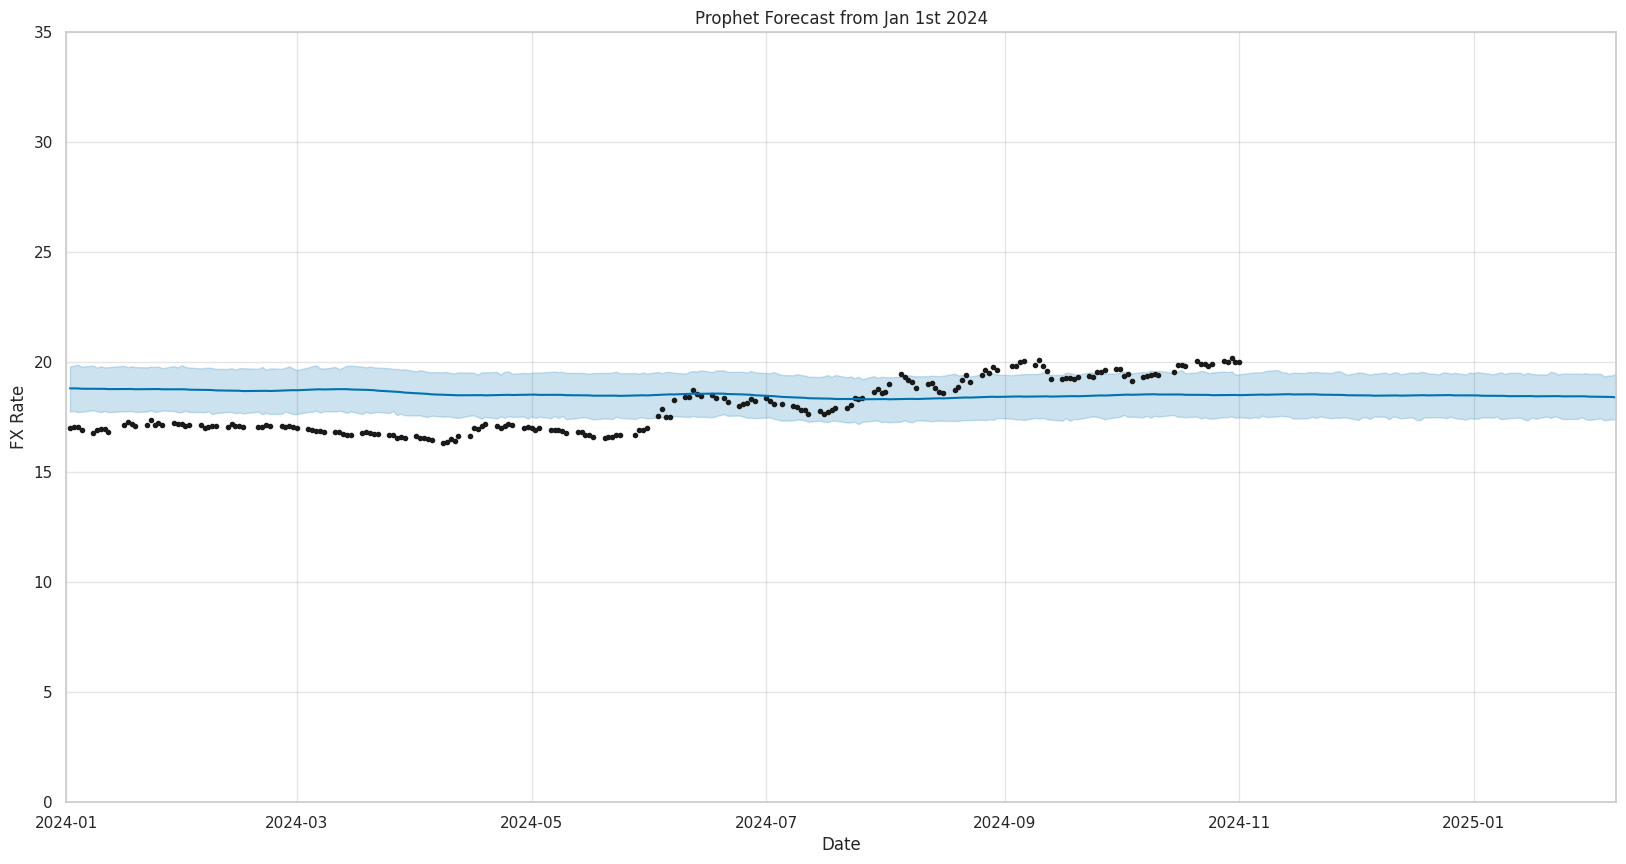

In [58]:
# Create a chart with a 1 year history to see whether it could be used as one of our final charts

# Create dataframe with data from begin Jan 2024
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2024-01-01']

# Calculate / Specify start and end dates
start_date = mdates.datestr2num('2024-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

# Plot subplots
fig, ax = plt.subplots(figsize=(20, 10))

# Plot charts
model.plot(filtered_forecast, ax=ax)

#Set X, Y labels and Title
ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2024')

#Set X and Y limits
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)

# Show plot
plt.show()

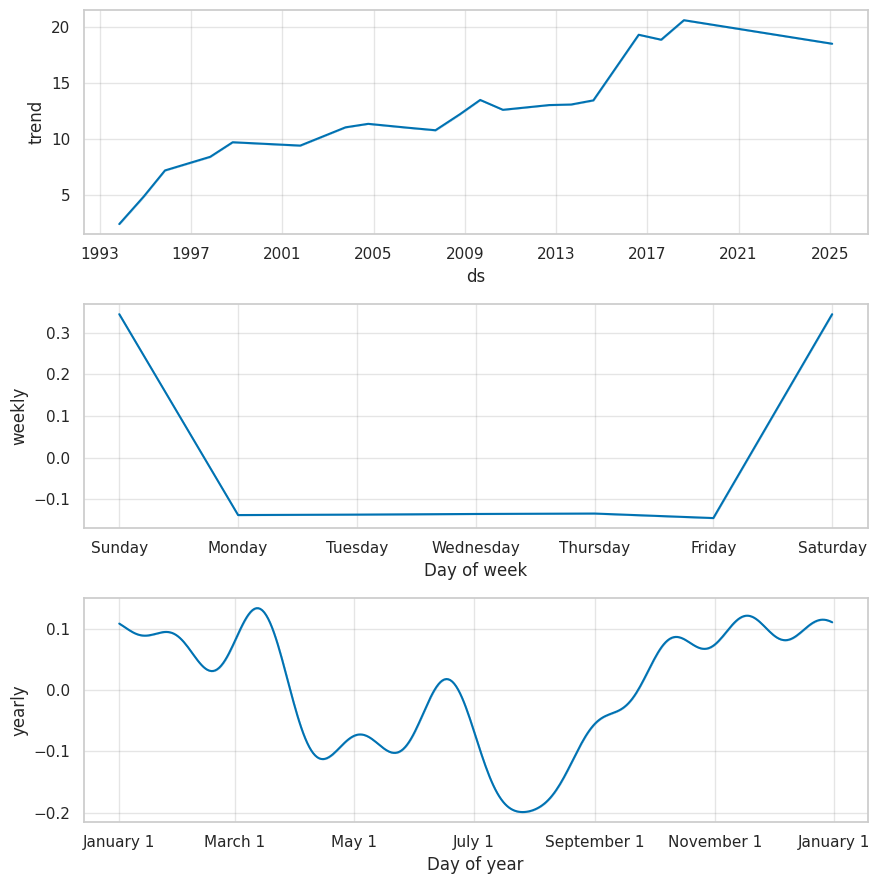

In [59]:
# Use the plot_components function to visualize the forecast results
figures = model.plot_components(forecast_trends)

In [60]:
# At this point, it's useful to set the `datetime` index of the forecast data.
forecast_trends = forecast_trends.set_index(["ds"])
forecast_trends.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
1993-11-08,2.441227,1.381726,3.406445,2.441227,2.441227,-0.038989,-0.038989,-0.038989,-0.137743,-0.137743,-0.137743,0.098754,0.098754,0.098754,0.0,0.0,0.0,2.402238
1993-11-09,2.447441,1.355848,3.385287,2.447441,2.447441,-0.034061,-0.034061,-0.034061,-0.136663,-0.136663,-0.136663,0.102602,0.102602,0.102602,0.0,0.0,0.0,2.413379
1993-11-10,2.453655,1.354366,3.394846,2.453655,2.453655,-0.028858,-0.028858,-0.028858,-0.135132,-0.135132,-0.135132,0.106274,0.106274,0.106274,0.0,0.0,0.0,2.424797
1993-11-12,2.466082,1.350720,3.459161,2.466082,2.466082,-0.032184,-0.032184,-0.032184,-0.144958,-0.144958,-0.144958,0.112774,0.112774,0.112774,0.0,0.0,0.0,2.433898
1993-11-15,2.484723,1.470601,3.483467,2.484723,2.484723,-0.018330,-0.018330,-0.018330,-0.137743,-0.137743,-0.137743,0.119413,0.119413,0.119413,0.0,0.0,0.0,2.466393


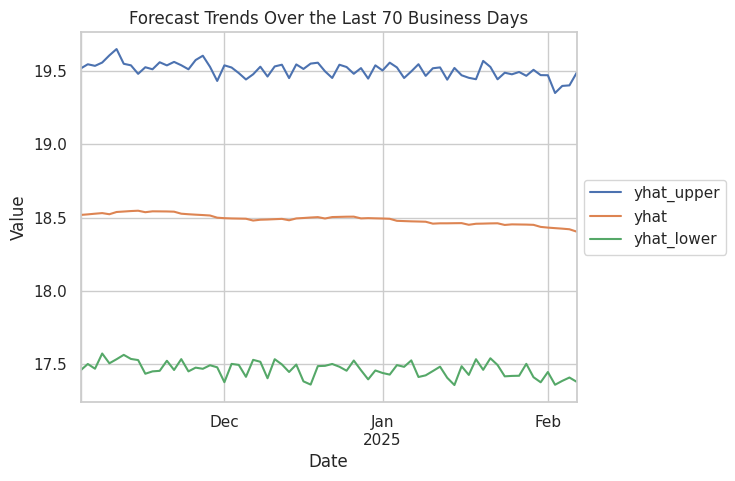

In [61]:
# Plot the yhat, yhat_lower, and yhat_upper columns for the last 70 business days
forecast_trends[["yhat_upper","yhat", "yhat_lower"]].iloc[-70:, :].plot()

# Customize the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place the legend outside on the right

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Forecast Trends Over the Last 70 Business Days")
plt.show()


In [62]:
# Create a DataFrame that contains just last 70 businesss days
forecast_90_days = forecast_trends.iloc[-70:, :][["yhat_upper", "yhat_lower", "yhat"]]

forecast_90_days = forecast_90_days.rename(
     columns={
        "yhat_upper": "Best Case",
        "yhat_lower": "Worst Case",
        "yhat": "Most Likely Case"
    }
)

# Review the last five rows of the DataFrame
forecast_90_days.head()

,Best Case,Worst Case,Most Likely Case
ds,,,
2024-11-04,19.515580,17.459538,18.517989
2024-11-05,19.544492,17.502651,18.521928
2024-11-06,19.533694,17.470339,18.526464
2024-11-07,19.556181,17.574070,18.530553
2024-11-08,19.605011,17.507244,18.522747


In [63]:
#Display the average price by month, so that index shows month name
forecast_90_days = forecast_90_days.groupby([forecast_90_days.index.year, forecast_90_days.index.month]).mean()

forecast_90_days

Best Case  Worst Case  Most Likely Case
ds   ds                                         
2024 11  19.541979   17.496017         18.529674
     12  19.505839   17.465420         18.494739
2025 1   19.492821   17.453469         18.462984
     2   19.420412   17.397654         18.421833